Random Forest model runs for Trip Purpose Estimation using data from the 2017 MTL Trajet

# Loading packages

In [1]:
import pandas as pd
import geopandas as gpd
import shapely
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import collections
import sklearn
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.ensemble
import rfpimp
from sklearn.feature_selection import SelectFromModel
import random
import datetime

# oversampling
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import RandomUnderSampler

%matplotlib inline

/home/thomaskeel/anaconda3/envs/datasci/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


# Loading data

The data should contain the nearby POI information from the Google Place API. 

`Preprocessing is needed`

Consider using the POI types from the paper by Emagun et al.

In [2]:
X_all = pd.read_csv('../../Data/model_inputs/gdf_2017_X.csv')
y_all = pd.read_csv('../../Data/model_inputs/gdf_2017_y.csv')

The encoding of **purpose** and **mode** is as follows. Note that the trips of home and work have been removed.

- purpose: {'leisure': 0, 'food_drink': 1, 'shops': 2, 'pick_up_drop_off': 3, 'education': 4, 'health': 5}
- mode: {'walking': 0, 'public_transport': 1, 'car': 2, 'cycling': 3, 'taxi': 4, 'car_sharing': 5,'mixed':6, 'other':7, 'not_available':8}

In [3]:
y_all['purpose'].value_counts()

0    9143
2    8357
1    3107
4    2769
3    1571
5    1044
Name: purpose, dtype: int64

In [4]:
X_all['mode'].value_counts()

2    9906
0    5913
3    3514
1    3380
6    2635
5     407
4     111
8      65
7      60
Name: mode, dtype: int64

In [5]:
X_all.columns

Index(['id_trip', 'mode', 'distance_m', 'duration', 'weekday', 'morning',
       'midday', 'afternoon', 'evening', 'midnight', 'lat', 'long'],
      dtype='object')

The meaning of X variables is shown below.

| Variable | Meaning | Unit |
|:-------- | :-------- | :---- |
| id_trip | Unique ID | NA |
| mode | Trip mode | {'walking': 0, 'public_transport': 1, 'car': 2, 'cycling': 3, 'taxi': 4, 'car_sharing': 5,'mixed':6, 'other':7, 'not_available':8}|
| duration | Trip duration | Second |
| distance_m | Euclidean trip distance calculated from nodes along a Shapely LineString object | Metre |
| weekday | Whether this trip occurs in a weekday (Monday to Friday) | {1:True, 0:False} |
| precip | Total precipitation within a given hour on a given date | mm |
| temp | Average Temperature within a given hour on a given date | Celcius |
| morning | Whether this trip occurs in the morning time 0600-1059 | {1:True, 0:False} |
| afternoon | Whether this trip occurs in the afternoon time 1100-1359 | {1:True, 0:False} |
| evening | Whether this trip occurs in the evening time 1700-2159 | {1:True, 0:False} |
| midnight | Whether this trip occurs in the midnight time 2200-0559 | {1:True, 0:False} |
| long | The x coordinate of the ending point in the TBC reference system | Metre |
| lat | The y coordinate of the ending point in the TBC reference system | Metre |

In [6]:
# replace False and True with 0 and 1, respectively
X_all = X_all.replace({True: 1, False: 0})

Add descriptive analysis of nearby POIs, and compare this with the description of LTPD (in Section 5.1) [Thomas] X_all.head()

In [7]:
y_all.columns

Index(['purpose'], dtype='object')

In [8]:
print('The size of each trip purpose:')
y_all['purpose'].value_counts()

The size of each trip purpose:


0    9143
2    8357
1    3107
4    2769
3    1571
5    1044
Name: purpose, dtype: int64

# Variable settings and algorithms

 There are four settings of variables
 - Basic (without nearby trip purposes or Google nearby Places)
 - Basic and nearby trips
 - Basic and Google POIs
 - Baisc and nearby trips and Google POIs 
 
 
 There are two algorithms:
 - Random Forest
 - Nested Logit
 
 
 Based on exhaustive combinations of settings and algorithms, eight models will be trained.
 
 In this notebook, we will compare four random forest models. Each model will be tuned using GridSearchCV.
 
 The basic variables include the following:
 - 'mode'
 - 'duration'
 - 'distance_m'
 - 'weekday'
 - 'precip'
 - 'temp'
 - 'morning' 
 - 'midday' 
 - 'afternoon'
 - 'evening'
 - 'midnight'
 
 
 There is no need to normalise continuous variables before using RF.

## Utility functions

## A function for re-projecting that data

In [9]:
def change_crs_of_X(X, crs_from="EPSG:4236",crs_to="EPSG:3347"):
    """
        Function for translating the data into Canada Lambert projection 
        EPSG: 3347, so that the base unit is 1 m
    """
    new_X = X.copy()
    new_X['geometry'] = new_X.apply(lambda row: shapely.geometry.Point(row['long'],row['lat']),axis=1)
    new_X = gpd.GeoDataFrame(new_X,crs=crs_from)
    new_X = new_X.to_crs(crs_to)
    return new_X

### A function that runs a standard random forest model

In [88]:
def run_rf(X_train, X_test, y_train, y_test, n_estimators=2000, max_depth=20):
    """
        Run a random forest classification model
    """
    clf = sklearn.ensemble.RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
    clf.fit(X_train, y_train)
    score = clf.score(X_test,y_test)
    preds = clf.predict(X_test)
    #print("Random Forest Classifcation accuracy:", score)
    return clf, score, preds

### A function to compute the proportions of nearby trip purposes in the training data (TK)

In [11]:
def compute_nearby_purposes(y_train, X_train, X_test, buffer_size_m=200):
    """
        Augment the training and testing data with the proportions of nearby trip purposes in the training data.
        :param y_train: (dataframe) the trip purpose of the training data, which is used to compute proportions of nearby trip purposes. Should contain a column of 'purpose'
        :param X_train: (dataframe) the predictor variables of the training data. Should contain three columns of 'id', endx' and 'endy'.
        :param X_test: (dataframe) the predictor variables of the testing data. Should contain two columns of 'id', 'endx' and 'endy'.
        :param buffer_size_m: (int) the size of the buffer in metres around each trip end.
        :return: (list) [X_train_aug, X_test_aug]. X_train_aug and X_test_aug are the X_train and X_test augmented with extra columns, respectively. The new columns are ['p_nearby_0', 'p_nearby_1', 'p_nearby_2', 'p_nearby_3', 'p_nearby_4', 'p_nearby_5']
        Note: when selecting the trips close to a trip in the training data, remember to exclude this trip itself using the 'id' column.
        Note: EPSG:3347 == Canada Lambert Projection
    """
    ## merge train and test X back together
    all_X = pd.concat([X_train, X_test],axis=0)
    
    ## initialise a geo-dataframe of all the X values and create a buffer of 200 m around each trip (for each row)
    geo_X = change_crs_of_X(all_X)
    
    # calculate 200 m buffers around each trip end point
    geo_X['buffers'] = geo_X['geometry'].apply(lambda row: row.buffer(buffer_size_m))
    
    # get a geo-dataframe with only the Trip ID,trip end buffer and trip purpose
    only_buffers = geo_X[['id_trip','buffers']]
    only_buffers = gpd.GeoDataFrame(only_buffers.rename(columns={'buffers':'geometry'}), crs="EPSG:3347")
    
    
    ## intialise a geo-dataframe of only the training data
    # Note: only the purposes of trips of the training dataset are known so this is why we need to create a seperate geoDataFrame of only the training data
    all_train = pd.concat([X_train,y_train],axis=1)
    all_train.reset_index(drop=True,inplace=True)
    geo_train = change_crs_of_X(all_train)

    ## perform the spatial join between a buffer of each trip and trip end points from exclusively the training data.
    # Note: here we are extracting the purpose of trips where the trip end points from the training geo-dataframe (type==Point) intersect with a buffer of all the trip end points (type==Polygon) 
    joined_data = gpd.sjoin(only_buffers, geo_train, op='intersects', how='left')

    ## drop duplicates (as each trip will fall within a buffer of itself)
    to_drop = joined_data[['id_trip_left','id_trip_right']].apply(lambda row: True \
                                                                if row['id_trip_left'] == row['id_trip_right']\
                                                                else False, axis=1)
    joined_data = joined_data[~to_drop]
    
    ## Compute the proportion of nearby purposes types for each trip/row
    grouped_data = joined_data.groupby(['id_trip_left', 'purpose']).agg({'mode':'count'})
    grouped_data = grouped_data.unstack().apply(lambda row: row/row.sum(),axis=1)['mode'].reset_index()
    grouped_data = grouped_data.fillna(0.0)
    
    ## rename columns
    new_columns = ['id_trip','p_nearby_0','p_nearby_1','p_nearby_2','p_nearby_3','p_nearby_4',\
                       'p_nearby_5']
    grouped_data.columns = new_columns
    
    ## Merge p_nearby columns back to X_train and X_test
    all_X = all_X.merge(grouped_data, on='id_trip', how='left')
    all_X = all_X.fillna(0.0)
    X_train_aug = X_train.merge(all_X[new_columns], on='id_trip')
    X_test_aug = X_test.merge(all_X[new_columns], on='id_trip')
    return X_train_aug, X_test_aug

# Basic RF

In [89]:
basic_variables = ['mode', 'duration', 'distance_m', 'weekday',
    'morning', 'midday', 'afternoon', 'evening', 'midnight']

# needed for nearby purpose computation 
temporary_variables = ['id_trip','long','lat']

# extract all variables
X_all_basic_variables = X_all[basic_variables + temporary_variables]

In [90]:
print(X_all_basic_variables.shape)
print(y_all.shape)
print(np.ravel(y_all).shape)

(25991, 12)
(25991, 1)
(25991,)


In [91]:
X_all_basic_variables

,mode,duration,distance_m,weekday,morning,midday,afternoon,evening,midnight,id_trip,long,lat
0,2,862,9935.922336,1,1,0,0,0,0,150744,-73.545318,45.550661
1,2,1873,6832.113937,1,0,1,0,0,0,35763,-73.472673,45.408982
2,2,1165,12233.968564,1,0,1,0,0,0,323826,-73.720401,45.610037
3,2,820,3612.405991,1,0,1,0,0,0,375668,-73.545622,45.578748
4,2,1316,26428.385191,1,0,0,1,0,0,212877,-73.318776,45.632435
...,...,...,...,...,...,...,...,...,...,...,...,...
25986,1,245,318.697272,1,0,0,0,0,1,187909,-73.597794,45.531788
25987,2,142,325.659195,1,0,0,0,0,1,317829,-73.570546,45.603296
25988,1,1296,2481.960790,1,0,0,0,0,1,182050,-73.577226,45.515994
25989,2,520,2983.535698,1,0,0,0,0,1,312741,-73.569639,45.490044


#### test time series split

In [98]:
# Time series split
tscv = sklearn.model_selection.TimeSeriesSplit(n_splits=5)

# Run models based on split time series
for train_index, test_index in tscv.split(X_all_basic_variables):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X_all_basic_variables.iloc[train_index], X_all_basic_variables.iloc[test_index]
    y_train, y_test = y_all.iloc[train_index], y_all.iloc[test_index]
    
    # compute nearby purposes
    X_train, X_test = compute_nearby_purposes(y_train, X_train, X_test, 200)
    # preserve Trip IDs of training and testing data
    X_train_IDs = X_train['id_trip']
    X_test_IDs = X_test['id_trip']
    
    # remove columns which are not needed
    X_train = X_train.drop(columns=temporary_variables, axis=1)
    X_test = X_test.drop(columns=temporary_variables, axis=1)
    
    # flatten y train data
    y_train = np.ravel(y_train)
    y_test = np.ravel(y_test)
    
    # run the random forest algorithm on this dataset
    rf_clf, rf_accuracy_rest, rf_pred_test = run_rf(X_train, X_test, y_train, y_test)
    
    # print results
    print("Accuracy on training data: ", rf_clf.score(X_train, y_train))
    print("Accuracy on testing data: ", rf_accuracy_rest)
    
    print(sklearn.metrics.classification_report(y_test, rf_pred_test))
    

TRAIN: [   0    1    2 ... 4333 4334 4335] TEST: [4336 4337 4338 ... 8664 8665 8666]
Accuracy on training data:  0.9910055350553506
Accuracy on testing data:  0.4975756176402678
              precision    recall  f1-score   support

           0       0.54      0.62      0.58      1738
           1       0.26      0.14      0.18       498
           2       0.50      0.54      0.52      1473
           3       0.27      0.14      0.18       241
           4       0.54      0.63      0.58       252
           5       0.24      0.07      0.11       129

    accuracy                           0.50      4331
   macro avg       0.39      0.36      0.36      4331
weighted avg       0.47      0.50      0.48      4331

TRAIN: [   0    1    2 ... 8664 8665 8666] TEST: [ 8667  8668  8669 ... 12995 12996 12997]
Accuracy on training data:  0.984654436367832
Accuracy on testing data:  0.5190487185407527
              precision    recall  f1-score   support

           0       0.50      0.59      0.

##### back to strat split

In [14]:
# split training testing data
rd_state = 42

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X_all_basic_variables, y_all, stratify=y_all, random_state=rd_state)

In [15]:
# compute nearby purposes
X_train, X_test = compute_nearby_purposes(y_train, X_train, X_test, 200)

In [16]:
# preserve Trip IDs of training and testing data
X_train_IDs = X_train['id_trip']
X_test_IDs = X_test['id_trip']

In [17]:
# remove columns which are not needed
X_train = X_train.drop(columns=temporary_variables, axis=1)
X_test = X_test.drop(columns=temporary_variables, axis=1)

In [18]:
# flatten y train data
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

In [19]:
# run the random forest algorithm on this dataset
rf_clf, rf_accuracy_rest, rf_pred_test = run_rf(X_train, X_test, y_train, y_test)

In [20]:
# print results
print("Accuracy on training data: ", rf_clf.score(X_train, y_train))
print("Accuracy on testing data: ", rf_accuracy_rest)

Accuracy on training data:  1.0
Accuracy on testing data:  0.5320098491843644


The prediciton accuracy on the training and testing data is 1.0 and 0.511, respectively, indicating that the model is overfitting.

In [21]:
print(sklearn.metrics.classification_report(y_test, rf_pred_test))

              precision    recall  f1-score   support

           0       0.53      0.67      0.59      2286
           1       0.33      0.14      0.20       777
           2       0.52      0.59      0.55      2089
           3       0.36      0.17      0.23       393
           4       0.73      0.70      0.72       692
           5       0.38      0.13      0.20       261

    accuracy                           0.53      6498
   macro avg       0.48      0.40      0.41      6498
weighted avg       0.51      0.53      0.51      6498



It is seen that the F1 is the highest for the trips of type 0 and 2, and the lowest for type 3 and 5.

## Feature importance

In [22]:
# n_samples is set as 5000 by default. 
# Setting n_samples as -1 means entire validation set
# the score metric used is accuracy, aka number of records that are correctly predicted
imp = rfpimp.importances(rf_clf, X_test, y_test, n_samples=-1)

In [23]:
print(imp)

            Importance
Feature               
p_nearby_4    0.038473
p_nearby_2    0.028624
midnight      0.020160
weekday       0.014774
p_nearby_0    0.014004
midday        0.011080
mode          0.009388
duration      0.004463
distance_m    0.003232
p_nearby_3    0.001385
evening       0.001077
morning       0.000923
p_nearby_5    0.000769
afternoon    -0.002155
p_nearby_1   -0.003693


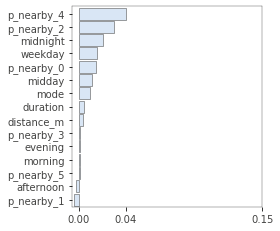

In [24]:
viz = rfpimp.plot_importances(imp)
viz.view()

It can be seen that the most important variables are:
- purpose_nearby_2 # shops
- purpose_nearby_4 # education
- mode
- temp
- purpose_nearby_0 # leisure
- weekday
- purpose_nearby_1 # food/drink
- distance_m
- purpose_nearby_3 # pick-up/drop-off
- purpose_nearby_5 # health
- midnight
- duration

## Model tuning

The hyperparameter of **n_estimators** will be tuned using *GridSearchCV*.

In [25]:
# testing on different n_estimators
list_n_estimators = [200, 1000, 2000]

# by default n_estimator in random forest is 100
parameters = {'n_estimators': list_n_estimators}

# use the default 5-fold cross validation. 
# About CV: For integer/None inputs, if the estimator is a classifier and y is either binary or multiclass, StratifiedKFold is used. 
# In all other cases, KFold is used.
gscv_rfc = sklearn.model_selection.GridSearchCV(sklearn.ensemble.RandomForestClassifier(), parameters)
gscv_rfc.fit(X_train, y_train)

print("Best parameters set found on development set:")
print()
print(gscv_rfc.best_params_)
print()
print("Grid scores on development set:")
print()
means = gscv_rfc.cv_results_['mean_test_score']
stds = gscv_rfc.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, gscv_rfc.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full evaluation set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, gscv_rfc.predict(X_test)
print(sklearn.metrics.classification_report(y_true, y_pred))


Best parameters set found on development set:

{'n_estimators': 200}

Grid scores on development set:

0.535 (+/-0.017) for {'n_estimators': 10}
0.558 (+/-0.010) for {'n_estimators': 50}
0.566 (+/-0.010) for {'n_estimators': 100}
0.570 (+/-0.015) for {'n_estimators': 200}

Detailed classification report:

The model is trained on the full evaluation set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.54      0.67      0.60      2286
           1       0.33      0.13      0.19       777
           2       0.53      0.61      0.57      2089
           3       0.39      0.18      0.25       393
           4       0.73      0.71      0.72       692
           5       0.37      0.13      0.20       261

    accuracy                           0.54      6498
   macro avg       0.48      0.41      0.42      6498
weighted avg       0.52      0.54      0.51      6498



In [26]:
# testing on different max_depth

# by default n_estimator in random forest is 100
parameters = {'max_depth': [10, 20, 50, 100]}

# use the default 5-fold cross validation. 
# About CV: For integer/None inputs, if the estimator is a classifier and y is either binary or multiclass, StratifiedKFold is used. 
# In all other cases, KFold is used.
gscv_rfc = sklearn.model_selection.GridSearchCV(sklearn.ensemble.RandomForestClassifier(), parameters)
gscv_rfc.fit(X_train, y_train)

print("Best parameters set found on development set:")
print()
print(gscv_rfc.best_params_)
print()
print("Grid scores on development set:")
print()
means = gscv_rfc.cv_results_['mean_test_score']
stds = gscv_rfc.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, gscv_rfc.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full evaluation set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, gscv_rfc.predict(X_test)
print(sklearn.metrics.classification_report(y_true, y_pred))


Best parameters set found on development set:

{'max_depth': 20}

Grid scores on development set:

0.560 (+/-0.014) for {'max_depth': 10}
0.571 (+/-0.019) for {'max_depth': 20}
0.569 (+/-0.016) for {'max_depth': 50}
0.567 (+/-0.017) for {'max_depth': 100}

Detailed classification report:

The model is trained on the full evaluation set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.54      0.68      0.60      2286
           1       0.36      0.13      0.19       777
           2       0.53      0.62      0.57      2089
           3       0.39      0.16      0.23       393
           4       0.73      0.70      0.72       692
           5       0.40      0.16      0.23       261

    accuracy                           0.54      6498
   macro avg       0.49      0.41      0.42      6498
weighted avg       0.52      0.54      0.52      6498



In [27]:
# testing n_estimators and max_depth

# by default n_estimator in random forest is 100
parameters = {'max_depth': [10, 20, 50, 100], 'n_estimators':[200, 1000, 2000]}

# use the default 5-fold cross validation. 
# About CV: For integer/None inputs, if the estimator is a classifier and y is either binary or multiclass, StratifiedKFold is used. 
# In all other cases, KFold is used.
gscv_rfc = sklearn.model_selection.GridSearchCV(sklearn.ensemble.RandomForestClassifier(), parameters)
gscv_rfc.fit(X_train, y_train)

print("Best parameters set found on development set:")
print()
print(gscv_rfc.best_params_)
print()
print("Grid scores on development set:")
print()
means = gscv_rfc.cv_results_['mean_test_score']
stds = gscv_rfc.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, gscv_rfc.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full evaluation set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, gscv_rfc.predict(X_test)
print(sklearn.metrics.classification_report(y_true, y_pred))

Best parameters set found on development set:

{'max_depth': 20, 'n_estimators': 100}

Grid scores on development set:

0.549 (+/-0.016) for {'max_depth': 10, 'n_estimators': 10}
0.558 (+/-0.016) for {'max_depth': 10, 'n_estimators': 50}
0.558 (+/-0.013) for {'max_depth': 10, 'n_estimators': 100}
0.557 (+/-0.013) for {'max_depth': 10, 'n_estimators': 200}
0.542 (+/-0.008) for {'max_depth': 20, 'n_estimators': 10}
0.568 (+/-0.014) for {'max_depth': 20, 'n_estimators': 50}
0.573 (+/-0.010) for {'max_depth': 20, 'n_estimators': 100}
0.573 (+/-0.009) for {'max_depth': 20, 'n_estimators': 200}
0.540 (+/-0.012) for {'max_depth': 50, 'n_estimators': 10}
0.565 (+/-0.008) for {'max_depth': 50, 'n_estimators': 50}
0.566 (+/-0.015) for {'max_depth': 50, 'n_estimators': 100}
0.568 (+/-0.011) for {'max_depth': 50, 'n_estimators': 200}
0.537 (+/-0.011) for {'max_depth': 100, 'n_estimators': 10}
0.565 (+/-0.015) for {'max_depth': 100, 'n_estimators': 50}
0.567 (+/-0.018) for {'max_depth': 100, 'n_est

The best hyperparameter found is **{'max_depth': 20, 'n_estimators': 200}**.

## Oversampling

In [28]:
X_train.columns

Index(['mode', 'duration', 'distance_m', 'weekday', 'morning', 'midday',
       'afternoon', 'evening', 'midnight', 'p_nearby_0', 'p_nearby_1',
       'p_nearby_2', 'p_nearby_3', 'p_nearby_4', 'p_nearby_5'],
      dtype='object')

In [29]:
# define categorical variables
list_categorical_var = ['mode', 'weekday', 'morning', 'midday', 'afternoon', 'evening', 'midnight']
mark_cateogrical_var = [e in list_categorical_var for e in X_train.columns]
rd_state = 42

sm = SMOTENC(random_state=rd_state, categorical_features=mark_cateogrical_var)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [30]:
# check number of trip purposes in y_train
print("Number per trip purpose in y_train")
print(pd.Series(y_train).value_counts())
print("Number per trip purpose in y_train_res")
print(pd.Series(y_train_res).value_counts())
# check number of trip purposes in y_train_res

Number per trip purpose in y_train
0    6857
2    6268
1    2330
4    2077
3    1178
5     783
dtype: int64
Number per trip purpose in y_train_res
0    6857
1    6857
2    6857
3    6857
4    6857
5    6857
dtype: int64


In [31]:
rf, rf_accuracy_test, rf_pred_test = run_rf(X_train, X_test, y_train, y_test,\
                                                        n_estimators=200, max_depth=20)
print("Accuracy on training data: ", rf_clf.score(X_train, y_train))
print("Accuracy on testing data: ", rf_accuracy_test)

Accuracy on training data:  1.0
Accuracy on testing data:  0.5426285010772546


In [32]:
print(sklearn.metrics.classification_report(y_test, rf_pred_test))

              precision    recall  f1-score   support

           0       0.54      0.68      0.60      2286
           1       0.38      0.13      0.19       777
           2       0.53      0.61      0.57      2089
           3       0.42      0.18      0.25       393
           4       0.73      0.71      0.72       692
           5       0.39      0.14      0.21       261

    accuracy                           0.54      6498
   macro avg       0.50      0.41      0.42      6498
weighted avg       0.52      0.54      0.52      6498



In [33]:
# compare the model using resampled data and 
rf_res, rf_res_accuracy_test, rf_res_pred_test = run_rf(X_train_res, X_test, y_train_res, y_test,\
                                                        n_estimators=200, max_depth=20)
# print results
print("Accuracy on training data: ", rf_clf.score(X_train_res, y_train_res))
print("Accuracy on testing data: ", rf_res_accuracy_test)

Accuracy on training data:  0.6530309659229012
Accuracy on testing data:  0.5060018467220684


The encoding of **purpose** and **mode** is as follows. Note that the trips of home and work have been removed.

- purpose: {'leisure': 0, 'food_drink': 1, 'shops': 2, 'pick_up_drop_off': 3, 'education': 4, 'health': 5}
- mode: {'walking': 0, 'public_transport': 1, 'car': 2, 'cycling': 3, 'public_transport, car': 4, 'other': 5}

In [34]:
print(sklearn.metrics.classification_report(y_test, rf_res_pred_test))

              precision    recall  f1-score   support

           0       0.57      0.58      0.58      2286
           1       0.28      0.28      0.28       777
           2       0.56      0.50      0.53      2089
           3       0.26      0.30      0.28       393
           4       0.67      0.73      0.70       692
           5       0.21      0.26      0.23       261

    accuracy                           0.51      6498
   macro avg       0.43      0.44      0.43      6498
weighted avg       0.51      0.51      0.51      6498



The oversampling doesn't lead to increase on the prediction accuracy. More predictor variables are needed for this task.

# Export model results
#### Functions in this section:
1. `model_setup` – Randomises the stratified train/test split and Trip IDs used  
2. `merge_predictions_to_data` – Code to join predictions of testing set back to original data

In [121]:
## Globals for columns to keep in the X data
BASIC_VARIABLES = ['mode', 'duration', 'distance_m', 'weekday',
        'morning', 'midday', 'afternoon', 'evening', 'midnight']
TEMPORARY_VARIABLES = ['id_trip','long','lat'] # needed for nearby purpose computation 


def model_setup(X, y, rd_state):
    """
        Sets up the model by carrying out the train/test splits as well as calculating the nearby purposes columns
        :param X: (dataframe) Independent variables
        :param y: (dataframe) Dependent variable
        :param rd_state: (int) Random state used for stratified train/test split
    """
    ## extract all variables needed based on global column list (see globals)
    X = X[BASIC_VARIABLES + TEMPORARY_VARIABLES]
    
    ## perform stratified train/test split
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
        X, y, stratify=y, random_state=rd_state)
    
    ## compute nearby purposes
    X_train, X_test = compute_nearby_purposes(y_train, X_train, X_test, 200)
    
    ## preserve Trip IDs of training and testing data
    X_train_IDs = X_train['id_trip']
    X_test_IDs = X_test['id_trip']
    
    # remove columns which are not needed
    X_train = X_train.drop(columns=TEMPORARY_VARIABLES, axis=1)
    X_test = X_test.drop(columns=TEMPORARY_VARIABLES, axis=1)
    
    # flatten y train data
    y_train = np.ravel(y_train)
    y_test = np.ravel(y_test)
    
    return X_train, X_test, y_train, y_test, X_train_IDs, X_test_IDs


def merge_predictions_to_data(original_data, predictions, X_test, y_test, test_ids):
    """
        Merge the predictions made by the model on the testing set back to the original data by merging on the trip ID
        :param original_data: (dataframe) Original dataframe from which train-test split is carried out
        :param predictions: (array) Predictions made on the testing set
        :param test_ids: (array) trip IDs for each row in the testing set
        :return original_data_with_preds: (dataframe) New dataframe containing only the testing set trip IDs and with predictions for these
    """
    ## make predictions into dataframe
    # apply series to the array of predictions
    predictions = pd.Series(predictions)
    # make a dataframe of ID, purpose and prediction
    prediction_data = pd.DataFrame([test_ids, y_test, predictions]).T
    prediction_data.columns = ['id_trip','purpose','prediction']
    # join back to X_test
    X_test = pd.concat([X_test, prediction_data],axis=1)
    return X_test
    
    ## merge to original
    # get columns to perform merge on (to miss out duplicates)
    cols_to_use = list(prediction_data.columns.difference(X_test.columns))
    cols_to_use += ['id_trip', 'p_nearby_0','p_nearby_1','p_nearby_2','p_nearby_3','p_nearby_4','p_nearby_5', 'purpose', 'prediction']

    # perform inner join
    original_data_with_preds = original_data.merge(X_test[cols_to_use], on='id_trip', how='inner')
    return original_data_with_preds
    

In [152]:
# set a random seed for train test split
random.seed(datetime.datetime.now())
rd_state = random.randint(0,1001)
print(rd_state)

653


In [153]:
%%time
# create new set of train/test data
X_train, X_test, y_train, y_test, X_train_IDs, X_test_IDs = model_setup(X_all, y_all, rd_state)

CPU times: user 28.1 s, sys: 269 ms, total: 28.4 s
Wall time: 28.2 s


In [154]:
# carry out modelling
rf, rf_accuracy_test, rf_preds = run_rf(X_train, X_test, y_train, y_test,\
                                                        n_estimators=200, max_depth=20)
print('accuracy on testing data:', rf_accuracy_test)

accuracy on testing data: 0.546321945213912


In [155]:
## DATA CHECK: to see if the ids still match up between the X_test and the original data
print(X_test.iloc[0])
X_all.loc[X_all.id_trip == X_test_IDs[0]]

mode             2.000000
duration       703.000000
distance_m    1996.287779
weekday          1.000000
morning          0.000000
midday           0.000000
afternoon        0.000000
evening          1.000000
midnight         0.000000
p_nearby_0       0.000000
p_nearby_1       0.000000
p_nearby_2       1.000000
p_nearby_3       0.000000
p_nearby_4       0.000000
p_nearby_5       0.000000
Name: 0, dtype: float64


,id_trip,mode,distance_m,duration,weekday,morning,midday,afternoon,evening,midnight,lat,long
5950,34003,2,1996.287779,703,1,0,0,0,1,0,45.593352,-73.54539


In [156]:
# merge predictions back to data
data_with_preds = merge_predictions_to_data(X_all, rf_preds, X_test, y_test, X_test_IDs)

In [157]:
y_test

array([2, 2, 0, ..., 5, 2, 1])

In [158]:
data_with_preds.columns

Index(['mode', 'duration', 'distance_m', 'weekday', 'morning', 'midday',
       'afternoon', 'evening', 'midnight', 'p_nearby_0', 'p_nearby_1',
       'p_nearby_2', 'p_nearby_3', 'p_nearby_4', 'p_nearby_5', 'id_trip',
       'purpose', 'prediction'],
      dtype='object')

In [159]:
# view data
data_with_preds.head()

,mode,duration,distance_m,weekday,morning,midday,afternoon,evening,midnight,p_nearby_0,p_nearby_1,p_nearby_2,p_nearby_3,p_nearby_4,p_nearby_5,id_trip,purpose,prediction
0,2,703,1996.287779,1,0,0,0,1,0,0.000000,0.000000,1.000000,0.000000,0.00,0.000000,34003,2,2
1,0,2180,3807.795577,1,0,1,0,0,0,0.057143,0.028571,0.714286,0.085714,0.00,0.114286,403058,2,2
2,0,469,315.522285,1,0,0,1,0,0,0.400000,0.133333,0.333333,0.000000,0.00,0.133333,171603,0,0
3,2,8419,10772.782900,0,0,0,0,1,0,1.000000,0.000000,0.000000,0.000000,0.00,0.000000,463958,0,0
4,1,4069,14644.240485,0,0,0,0,0,1,0.360000,0.040000,0.160000,0.080000,0.32,0.040000,151415,3,0


In [160]:
# append times for start and end of trip
start_end_times = gpd.read_file('../../Data/mtl_trajet/mtl_trajet_2017_final.shp')[['id_trip','starttime','endtime']]


In [161]:
# append lat and long 
X_all

,id_trip,mode,distance_m,duration,weekday,morning,midday,afternoon,evening,midnight,lat,long
0,150744,2,9935.922336,862,1,1,0,0,0,0,45.550661,-73.545318
1,35763,2,6832.113937,1873,1,0,1,0,0,0,45.408982,-73.472673
2,323826,2,12233.968564,1165,1,0,1,0,0,0,45.610037,-73.720401
3,375668,2,3612.405991,820,1,0,1,0,0,0,45.578748,-73.545622
4,212877,2,26428.385191,1316,1,0,0,1,0,0,45.632435,-73.318776
...,...,...,...,...,...,...,...,...,...,...,...,...
25986,187909,1,318.697272,245,1,0,0,0,0,1,45.531788,-73.597794
25987,317829,2,325.659195,142,1,0,0,0,0,1,45.603296,-73.570546
25988,182050,1,2481.960790,1296,1,0,0,0,0,1,45.515994,-73.577226
25989,312741,2,2983.535698,520,1,0,0,0,0,1,45.490044,-73.569639


In [163]:
data_with_preds = data_with_preds.merge(start_end_times, on='id_trip')
data_with_preds = data_with_preds.merge(X_all[['id_trip','lat','long']], on='id_trip')

In [164]:
data_with_preds.head()

,mode,duration,distance_m,weekday,morning,midday,afternoon,evening,midnight,p_nearby_0,...,p_nearby_3,p_nearby_4,p_nearby_5,id_trip,purpose,prediction,starttime,endtime,lat,long
0,2,703,1996.287779,1,0,0,0,1,0,0.000000,...,0.000000,0.00,0.000000,34003,2,2,2017-09-29 20:12:40,2017-09-29 20:24:23,45.593352,-73.545390
1,0,2180,3807.795577,1,0,1,0,0,0,0.057143,...,0.085714,0.00,0.114286,403058,2,2,2017-09-25 12:56:19,2017-09-25 13:32:39,45.541448,-73.561588
2,0,469,315.522285,1,0,0,1,0,0,0.400000,...,0.000000,0.00,0.133333,171603,0,0,2017-10-04 15:07:11,2017-10-04 15:15:00,45.547618,-73.665398
3,2,8419,10772.782900,0,0,0,0,1,0,1.000000,...,0.000000,0.00,0.000000,463958,0,0,2017-10-01 15:02:08,2017-10-01 17:22:27,45.527778,-73.536887
4,1,4069,14644.240485,0,0,0,0,0,1,0.360000,...,0.080000,0.32,0.040000,151415,3,0,2017-09-30 00:31:18,2017-09-30 01:39:07,45.524721,-73.522009


In [165]:
# save data 
# data_with_preds.to_csv('../../Data/model_outputs/predictions_17.csv',index=False)

# POI_RF

## One vs many
see: https://stackoverflow.com/questions/56090541/how-to-plot-precision-and-recall-of-multiclass-classifier/56092736

In [46]:
%%time
# create new set of train/test data
X_train, X_test, y_train, y_test, X_train_IDs, X_test_IDs = model_setup(X_17, y_17, rd_state=42)

NameError: name 'X_17' is not defined

In [47]:
sklearn.preprocessing.label_binarize(y_train, classes=[0,1,2,3,4,5])
y_train = sklearn.preprocessing.label_binarize(y_train, classes=[0,1,2,3,4,5])
y_test = sklearn.preprocessing.label_binarize(y_test, classes=[0,1,2,3,4,5])

In [48]:
import sklearn.multiclass

In [49]:
clf = sklearn.multiclass.OneVsRestClassifier(sklearn.ensemble.RandomForestClassifier(n_estimators=200,
                             max_depth=20,
                             random_state=42))
clf.fit(X_train, y_train)

y_score = clf.predict_proba(X_test)

In [50]:
clf.score(X_test, y_test)

0.3867343798091721

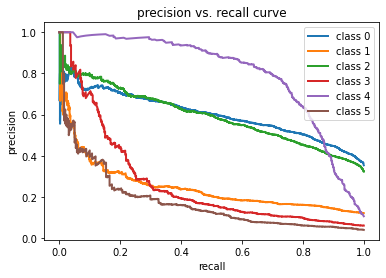

In [51]:
# precision recall curve
precision = dict()
recall = dict()
for i in range(6):
    precision[i], recall[i], _ = sklearn.metrics.precision_recall_curve(y_test[:, i],
                                                        y_score[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))

plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()